<a href="https://colab.research.google.com/github/abhidp55/Deep-Neural-Network-From-Scatch/blob/main/Deep_neural_network_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing libraries

In [23]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist

#Loading the data

In [24]:
(x_train,y_train),(x_test,y_test) = mnist.load_data()

##One hot encoding target features

In [25]:
def one_hot_array(Y):
    b = np.zeros((Y.size, Y.max() + 1))
    b[np.arange(Y.size), Y] = 1
    return b.T

In [26]:
y_train,y_test= one_hot_array(y_train), one_hot_array(y_test)

## Resizing and standardizing data

In [27]:
train_x_flatten = x_train.reshape(x_train.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = x_test.reshape(x_test.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
x_train = train_x_flatten/255.
x_test = test_x_flatten/255.

print ("train_x's shape: " + str(x_train.shape))
print ("test_x's shape: " + str(x_test.shape))

train_x's shape: (784, 60000)
test_x's shape: (784, 10000)


In [28]:
x_train = x_train[:, 0:5000]
x_test = x_test[:, 5000:10000]
y_train = y_train[:, 0:5000]
y_test = y_test[:, 5000:10000]

In [29]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(784, 5000)
(784, 5000)
(10, 5000)
(10, 5000)


#Initializing weights and biases

In [30]:
def initialize_parameters_deep(layer_dims):
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01 
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters

#Activation functions

In [31]:
def softmax(Z):
    t = np.exp(Z)
    t = t / t.sum(axis=0, keepdims=True)
    return t

def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    return A

def relu(Z):
    A = np.maximum(0,Z)    
    assert(A.shape == Z.shape)
    return A

#Forward propogation
-linear forward activation

In [32]:
def linear_activation_forward(A_prev, W, b, activation):
    
    if activation == "sigmoid":
        Z = np.dot(W, A_prev) + b
        A = sigmoid(Z)
    
    elif activation == "relu":
        Z = np.dot(W, A_prev) + b
        A = relu(Z)
        
    elif activation == "softmax":
        Z = np.dot(W, A_prev) + b
        A = softmax(Z)
    
    # Some assertions to check that shapes are right
    assert(Z.shape == (W.shape[0], A.shape[1]))
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    
    # Cache the necessary values for back propagation later
    cache = (A_prev, W, b, Z)

    return A, cache

##Forward prop and saving caches

In [33]:
def L_model_forward(X, parameters):

    caches = []
    A = X
    L = len(parameters) // 2                  # number of hidden layers in the neural network
    
    # Hidden layers 1 to L-1 will be Relu.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], activation="relu")
        caches.append(cache)
        
    # Output layer L will be softmax
    AL, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], activation="softmax")
    caches.append(cache)
    
    assert(AL.shape == (10, X.shape[1]))
            
    return AL, caches

##Computing cost function

In [34]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    
    cost = -1/m * np.sum(np.multiply(Y, np.log(AL)))    
    cost = np.squeeze(cost)      # To coerce data from [[17]] into 17
    assert(cost.shape == ())
    
    return cost

#Backpropogation
-linear backwards

In [35]:
def linear_backward(dZ, A_prev, W, b):
    m = A_prev.shape[1]

    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

##Activation functions(derivative)

In [36]:
def relu_backward(dA, cache):
    A_prev, W, b, Z = cache
    
    # Compute dZ
    dZ = np.array(dA, copy=True) # convert dz to a numpy array
    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)
    
    # Compute dA_prev, dW, db
    dA_prev, dW, db = linear_backward(dZ, A_prev, W, b)
    return dA_prev, dW, db

def softmax_backward(AL, Y, cache):
    A_prev, W, b, Z = cache
    
    # Compute dZ
    dZ = AL - Y
    
    # Compute dA_prev, dW, db
    dA_prev, dW, db = linear_backward(dZ, A_prev, W, b)
    return dA_prev, dW, db

##Backward activation

In [37]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Backpropagation at layer L-1
    # The activation is softmax at layer L-1
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = softmax_backward(AL, Y, current_cache)
    
    # Backpropagation from layers L-2 to 1
    # The activations are relu at all these layers
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = relu_backward(grads["dA" + str(l+1)], current_cache)
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

##Updating weights and biases

In [38]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural network
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    
    return parameters

#Implementing N-layered neural network

In [39]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    costs = []                         

    # Step a: Initialise Parameters
    parameters = initialize_parameters_deep(layers_dims)
    
    # Iterative loops of gradient descent
    for i in range(0, num_iterations):

        # Step b: Forward Propagation
        AL, caches = L_model_forward(X, parameters)
        
        # Step c: Compute cost
        cost = compute_cost(AL, Y)
        
        # Step d: Backward Propagation
        grads = L_model_backward(AL, Y, caches)
        
        # Step e: Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 10 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 2.301968
Cost after iteration 100: 2.202133
Cost after iteration 200: 1.363735
Cost after iteration 300: 0.815412
Cost after iteration 400: 0.612682
Cost after iteration 500: 0.509682
Cost after iteration 600: 0.444023
Cost after iteration 700: 0.398038
Cost after iteration 800: 0.364673
Cost after iteration 900: 0.339668
Cost after iteration 1000: 0.320211
Cost after iteration 1100: 0.304549
Cost after iteration 1200: 0.291563
Cost after iteration 1300: 0.280571
Cost after iteration 1400: 0.271077
Cost after iteration 1500: 0.262719
Cost after iteration 1600: 0.255243
Cost after iteration 1700: 0.248419
Cost after iteration 1800: 0.242130
Cost after iteration 1900: 0.236317
Cost after iteration 2000: 0.230877
Cost after iteration 2100: 0.225757
Cost after iteration 2200: 0.220917
Cost after iteration 2300: 0.216313
Cost after iteration 2400: 0.211928


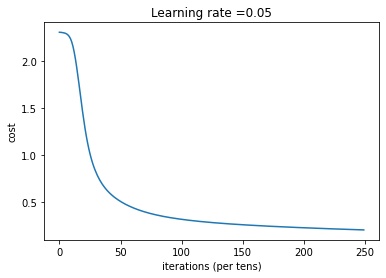

In [40]:
layers_dims = [784, 10, 10]
parameters = L_layer_model(x_train, y_train, layers_dims, learning_rate = 0.05, num_iterations = 2500, print_cost=True)

#Predictions

In [41]:
def predict(X, parameters):
    # Forward propagation
    probabilities, caches = L_model_forward(X, parameters)
    
    # Calculate Predictions (the highest probability for a given example is coded as 1, otherwise 0)
    predictions = (probabilities == np.amax(probabilities, axis=0, keepdims=True))
    predictions = predictions.astype(float)

    return predictions, probabilities

def evaluate_prediction(predictions, Y):
    m = Y.shape[1]
    predictions_class = predictions.argmax(axis=0).reshape(1, m)
    Y_class = Y.argmax(axis=0).reshape(1, m)
    
    return np.sum((predictions_class == Y_class) / (m))

In [42]:
pred_train, probs_train = predict(x_train, parameters)
print("Train set accuracy is: " + str(evaluate_prediction(pred_train, y_train)*100) )
pred_test, probs_test = predict(x_test, parameters)
print("Test set accuracy is: " + str(evaluate_prediction(pred_test, y_test)*100) )

Train set accuracy is: 94.28
Test set accuracy is: 92.78000000000002
